In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import OllamaEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from rank_bm25 import BM25Okapi
from langchain_community.llms import Ollama
from nltk.translate.bleu_score import sentence_bleu
from langchain.chains import RetrievalQA
from nltk.corpus import wordnet

In [2]:
pip install rank_bm25

Defaulting to user installation because normal site-packages is not writeable
  Using cached rank_bm25-0.2.2-py3-none-any.whl.metadata (3.2 kB)
Using cached rank_bm25-0.2.2-py3-none-any.whl (8.6 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load data and preprocess
loader = PyPDFLoader("story_long.pdf")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(docs)

In [3]:
# Initialize FAISS vector store and BM25 keyword search
#db_faiss = FAISS.from_documents(documents, OllamaEmbeddings())
db_faiss=FAISS.load_local('/Users/anu/Documents/IR_LAB/Package',OllamaEmbeddings())
bm25_corpus = [doc.page_content.split() for doc in documents]
bm25 = BM25Okapi(bm25_corpus)

In [4]:
# Load ground truth answers
ground_truth = pd.read_csv("ramayana_qa_dataset.csv")

In [5]:
# Chatbot prompt and LLM setup
prompt = ChatPromptTemplate.from_template("""
You are a chatbot designed to answer questions about the Hindu Mythological epic Ramayana. 
Answer the following question about the Ramayana in crisp in 30 words only
<context>
{context}
</context>
Question: {input}""")

llm = Ollama(model="llama2")

# Create LLMChain and Retrieval Chain
llm_chain = LLMChain(prompt=prompt, llm=llm)

retrieval_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db_faiss.as_retriever())

In [6]:
query_results = []

cumulative_metrics = {
    "k_values": [],
    "precision_at_k": [],
    "recall_at_k": [],
    "bleu_at_k": []
}

In [7]:
def expand_query(query):
    """Expand the query using synonyms from WordNet."""
    words = query.split()
    expanded_words = set(words)
    new_words=[]  # Use a set to avoid duplicates
    for word in words:
        synonyms = wordnet.synsets(word)
        for synonym in synonyms:
            for lemma in synonym.lemmas():
                new_words.append(lemma.name())  # Add synonyms
    return " ".join(words)

In [8]:
# Hybrid retrieval function
def hybrid_retrieval(query, top_k=5):
    faiss_results = db_faiss.similarity_search(query, k=top_k)
    bm25_query = query.split()
    bm25_scores = bm25.get_scores(bm25_query)
    top_bm25_indices = sorted(range(len(bm25_scores)), key=lambda i: bm25_scores[i], reverse=True)[:top_k]
    bm25_results = [documents[i] for i in top_bm25_indices]

    # Combine results, prioritizing FAISS
    seen = set()
    combined_results = []
    for result in faiss_results + bm25_results:
        doc_id = result.metadata.get('id')
        if doc_id not in seen:
            combined_results.append(result)
            seen.add(doc_id)
        if len(combined_results) >= top_k:
            break
    
    return combined_results

In [15]:
naive_results=[]
def naive_retrieval(query,top_k=5):
    return db_faiss.similarity_search(query, k=top_k)

def naive_get_response(query):
    expanded_query = expand_query(query)
    retrieved_docs = naive_retrieval(expanded_query, top_k=5)
    
    # Generate response using the retrieval chain
    response = retrieval_chain({"query": expanded_query, "context": "\n".join(doc.page_content for doc in retrieved_docs)})
    
     # Ensure the response has the expected structure
    if 'result' in response:
        naive_results.append((query,response['result']))  
    else:
        naive_results.append((query," "))

In [10]:
def get_response(query):
    
    expanded_query = expand_query(query)
    retrieved_docs = hybrid_retrieval(expanded_query, top_k=5)
    
    # Generate response using the retrieval chain
    response = retrieval_chain({"query": expanded_query, "context": "\n".join(doc.page_content for doc in retrieved_docs)})
    
     # Ensure the response has the expected structure
    if 'result' in response:
        query_results.append((query,response['result']))  
    else:
        query_results.append((query," "))


In [23]:
# Cumulative metrics at query levels
def compute_cumulative_metrics(ground_truth_df, query_results,every=5):
    cumulative_precision, cumulative_recall, cumulative_bleu = [], [], []
    k_values=[]
    precision_sum, recall_sum, bleu_sum = 0, 0, 0
    for i, (query, bot_response) in enumerate(query_results):

        true_answer = ground_truth_df[ground_truth_df['Question'] == query]['Answer'].values[0]

        if true_answer:
            truth_tokens = true_answer.lower().split()
            pred_tokens = bot_response.lower().split()

            # Precision and recall calculation
            precision = len(set(pred_tokens) & set(truth_tokens)) / len(pred_tokens) if pred_tokens else 0
            recall = len(set(pred_tokens) & set(truth_tokens)) / len(truth_tokens) if truth_tokens else 0
            bleu = sentence_bleu([truth_tokens], pred_tokens)
                
            precision_sum += precision
            recall_sum += recall
            bleu_sum += bleu
        
        if (i+1)%every==0:
            k_values.append(i+1)
            cumulative_precision.append(precision_sum / (i+1))
            cumulative_recall.append(recall_sum / (i+1))
            cumulative_bleu.append(bleu_sum / (i+1))
                
    return k_values, cumulative_precision, cumulative_recall, cumulative_bleu

In [12]:
# Visualize cumulative metrics at each k
def plot_cumulative_metrics(k_values, precision_at_k, recall_at_k, bleu_at_k):
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, precision_at_k, label="Precision@k", marker='o')
    plt.plot(k_values, recall_at_k, label="Recall@k", marker='o')
    plt.plot(k_values, bleu_at_k, label="BLEU@k", marker='o')
    plt.xlabel("Number of Queries (k)")
    plt.ylabel("Score")
    plt.title("Cumulative Metrics at k Queries")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
'''print("Finding predictins using RAG model:")
for i in range(ground_truth.shape[0]):
    if (i+1)%5==0:
        print("Query:",i+1)
    query=ground_truth.iloc[i,0]
    get_response(query)

pred_results=pd.DataFrame({'Question': [i[0] for i in query_results], 'Answer': [i[1] for i in query_results]})
pred_results.to_csv('rag_pred_results.csv', index=False)'''

In [13]:
pred_results=pd.read_csv("rag_pred_results.csv")
query_results=[(pred_results.iloc[i,0],pred_results.iloc[i,1]) for i in range(len(pred_results))]
    
k_values, precision_at_k, recall_at_k, bleu_at_k = compute_cumulative_metrics(ground_truth, query_results)

/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

In [14]:
cumulative_metrics["k_values"] = k_values
cumulative_metrics["precision_at_k"] = precision_at_k
cumulative_metrics["recall_at_k"] = recall_at_k
cumulative_metrics["bleu_at_k"] = bleu_at_k

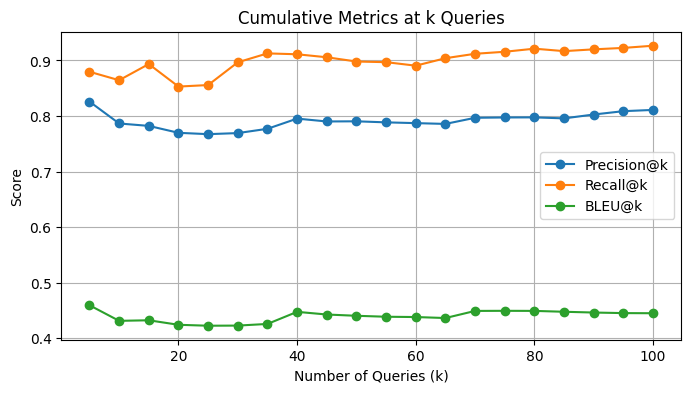

In [28]:
plot_cumulative_metrics(cumulative_metrics["k_values"], cumulative_metrics["precision_at_k"], cumulative_metrics["recall_at_k"], cumulative_metrics["bleu_at_k"])


#### Comparing hybrid model with naive FAISS retrieval

In [24]:
for i in range(ground_truth.head(10).shape[0]):
    query=ground_truth.iloc[i,0]
    naive_get_response(query)

query_results=[(naive_results[i][0],naive_results[i][1]) for i in range(len(naive_results))]
k_values, precision_at_k, recall_at_k, bleu_at_k = compute_cumulative_metrics(ground_truth.head(10), query_results,every=1)

/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/anu/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

### Naive FAISS retrieval results

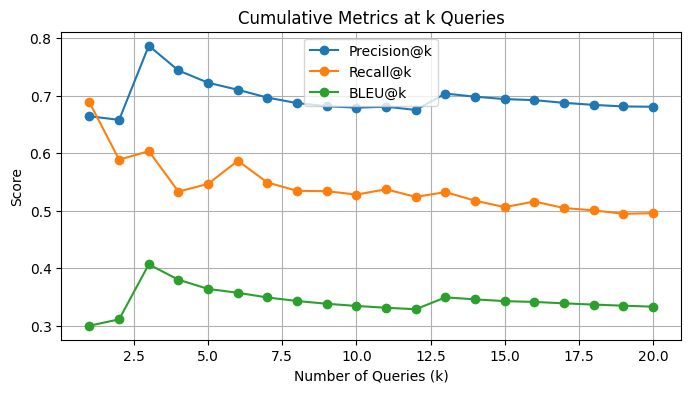

In [32]:
plot_cumulative_metrics(k_values, precision_at_k, recall_at_k, bleu_at_k)
